## 컬럼설명
([대회 및 데이터 링크](https://www.kaggle.com/c/bike-sharing-demand/data))

  * **datetime** - 시간. 연-월-일 시:분:초
  * **season** - 계절. 봄(1), 여름(2), 가을(3), 겨울(4)
  * **holiday** - 공휴일. 1이면 공휴일이며, 0이면 공휴일이 아님
  * **workingday** - 근무일. 1이면 근무일이며, 0이면 근무일이 아님
  * **weather** - 날씨. 1 ~ 4 사이의 값
    * 1: 아주 깨끗한 날씨 또는 아주 약간의 구름
    * 2: 약간의 안개와 구름
    * 3: 약간의 눈, 비가 오거나 천둥
    * 4: 아주 많은 비가 오거나 우박
  * **temp** - 온도. 섭씨(Celsius)
  * **atemp** - 체감 온도.섭씨(Celsius)
  * **humidity** - 습도(상대습도)
  * **windspeed** - 풍속
  * **casual** - 비회원(non-registered)의 자전거 대여량.
  * **registered** - 회원(registered)의 자전거 대여량.
  * **count** - 총 자전거 대여랑. 비회원(casual) + 회원(registered)과 동일

## 최종점수: 0.40713(리더보드 기준 상위 8.8% 위치)
### 유효분석
* **datetime컬럼을 년/월/일/시/분/초로 세분화하여 유의미/무의미한 feature 구분**
    * 년, 요일, 시 만 사용


* **windspped 컬럼에서 0의 값을 평균으로 대체**


* **습도와 온도를 이용하여 파생변수 생성: 불쾌지수(discomfort index) 컬럼**


* **casual과 registered의 대여패턴 분석으로 차이 발견**
    * test데이터에 casual과 registered가 없는 점 고려
    * 먼저 casual과 registered를 각각 예측한 뒤 이를 더한 값을 count에 할당하여 제출
    
    
* **GridSearch를 이용하여 hyper parameter 최적화**

## 데이터 로드

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")

print(train.shape)

train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


datetime이 object로 되어 있으므로 날짜로 인식하게 변환 필요.
이 경우 최초에 csv파일을 불러올 때 parse_dates = ["날짜 컬럼명"] 으로 옵션을 지정해 주면 된다.

In [3]:
train = pd.read_csv('train.csv', parse_dates = ['datetime'])

print(train.shape)

train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
print(train.dtypes)
# 아래와 같이 datetime의 data type이 변경된 것을 볼 수 있다.

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object


In [5]:
test = pd.read_csv('test.csv', parse_dates = ['datetime'])

print(test.shape)

test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## Preprocessing(전처리)

### Parse datetime
문자열(object)또는 날짜(datetime64)는 결국 하이픈과 콜론을 포함한 문자로 인식되어 머신러닝 알고리즘이 이해할 수 없다.

따라서 이를 숫자형으로 바꿔줘야 하는데, 가장 쉬운 방법은 다 따로 나누는 것

일단 object형을 datetime형으로 바꿔주었기 때문에 dt.year/month 등등의 명령어로 날짜컬럼의 데이터를 개별연도/월 등으로 나누는 게 가능하다.

In [6]:
train['datetime-year'] = train['datetime'].dt.year
train['datetime-month'] = train['datetime'].dt.month
train['datetime-day'] = train['datetime'].dt.day
train['datetime-hour'] = train['datetime'].dt.hour
train['datetime-minute'] = train['datetime'].dt.minute
train['datetime-second'] = train['datetime'].dt.second

또한 자전거 수요를 예측하기 위해서는 요일도 필요하다고 생각한다.

따라서 dt.dayofweek 명령어로 해당 일에 해당하는 요일을 숫자형으로 자동으로 나타나게 한다.

0은 월요일 6은 일요일이 된다.

In [7]:
train['datetime-dayofweek'] = train['datetime'].dt.dayofweek
print(train.shape)
train.head()

(10886, 19)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


나중에 요일별 시각화를 할 때 이해하기 쉽도록 dayofweek의 각 요소들을 단어형태로 변환

In [8]:
train.loc[train["datetime-dayofweek"] == 0, "datetime-dayofweek(word)"] = "Monday"
train.loc[train["datetime-dayofweek"] == 1, "datetime-dayofweek(word)"] = "Tuesday"
train.loc[train["datetime-dayofweek"] == 2, "datetime-dayofweek(word)"] = "Wednesday"
train.loc[train["datetime-dayofweek"] == 3, "datetime-dayofweek(word)"] = "Thursday"
train.loc[train["datetime-dayofweek"] == 4, "datetime-dayofweek(word)"] = "Friday"
train.loc[train["datetime-dayofweek"] == 5, "datetime-dayofweek(word)"] = "Saturday"
train.loc[train["datetime-dayofweek"] == 6, "datetime-dayofweek(word)"] = "Sunday"

print(train.shape)

train[["datetime","datetime-dayofweek", "datetime-dayofweek(word)"]].head()

(10886, 20)


,datetime,datetime-dayofweek,datetime-dayofweek(word)
0,2011-01-01 00:00:00,5,Saturday
1,2011-01-01 01:00:00,5,Saturday
2,2011-01-01 02:00:00,5,Saturday
3,2011-01-01 03:00:00,5,Saturday
4,2011-01-01 04:00:00,5,Saturday


In [9]:
test["datetime-year"] = test["datetime"].dt.year
test["datetime-month"] = test["datetime"].dt.month
test["datetime-day"] = test["datetime"].dt.day
test["datetime-hour"] = test["datetime"].dt.hour
test["datetime-minute"] = test["datetime"].dt.minute
test["datetime-second"] = test["datetime"].dt.second
test["datetime-dayofweek"] = test["datetime"].dt.dayofweek

print(test.shape)

test[["datetime","datetime-year","datetime-month","datetime-day","datetime-hour","datetime-minute","datetime-second","datetime-dayofweek"]].head()

(6493, 16)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek
0,2011-01-20 00:00:00,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,2011,1,20,4,0,0,3


In [10]:
test.loc[test["datetime-dayofweek"] == 0, "datetime-dayofweek(word)"] = "Monday"
test.loc[test["datetime-dayofweek"] == 1, "datetime-dayofweek(word)"] = "Tuesday"
test.loc[test["datetime-dayofweek"] == 2, "datetime-dayofweek(word)"] = "Wednesday"
test.loc[test["datetime-dayofweek"] == 3, "datetime-dayofweek(word)"] = "Thursday"
test.loc[test["datetime-dayofweek"] == 4, "datetime-dayofweek(word)"] = "Friday"
test.loc[test["datetime-dayofweek"] == 5, "datetime-dayofweek(word)"] = "Saturday"
test.loc[test["datetime-dayofweek"] == 6, "datetime-dayofweek(word)"] = "Sunday"

print(test.shape)

test[["datetime","datetime-dayofweek", "datetime-dayofweek(word)"]].head()

(6493, 17)


,datetime,datetime-dayofweek,datetime-dayofweek(word)
0,2011-01-20 00:00:00,3,Thursday
1,2011-01-20 01:00:00,3,Thursday
2,2011-01-20 02:00:00,3,Thursday
3,2011-01-20 03:00:00,3,Thursday
4,2011-01-20 04:00:00,3,Thursday


## EDA

In [11]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### datetime 분석
 날짜컬럼을 확실히 이해하고 분석하는 것이 본 경진대회의 핵심.

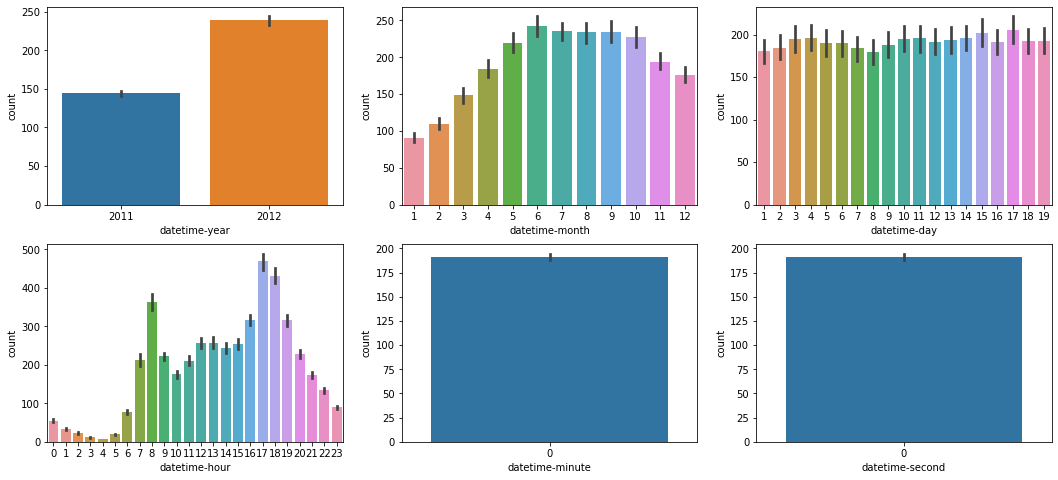

In [12]:
# matplotlib의 subplots 이용, 본 함수는 복수의 시각화를 한 화면에 띄무게 함

figure, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)

figure.set_size_inches(18,8)

# seaborn의 barplot이 보기 적절해 보임. 연/월/일/시/분/초 를 나타내 보겠음

sns.barplot(data=train, x=train["datetime-year"], y="count", ax=ax1)
sns.barplot(data=train, x=train["datetime-month"], y="count", ax=ax2)
sns.barplot(data=train, x=train["datetime-day"], y="count", ax=ax3)
sns.barplot(data=train, x=train["datetime-hour"], y="count", ax=ax4)
sns.barplot(data=train, x=train["datetime-minute"], y="count", ax=ax5)
sns.barplot(data=train, x=train["datetime-second"], y="count", ax=ax6)

plt.show()

 1. datetime-day: 19일까지 밖에 없다. 이 경우 머신러닝에 feature로 사용하면 overfitting 가능성이 높다.
 2. minute, second: 다 0으로 디폴트. feature로 부적절
 3. 결론: year, month, hour가 유의미한 feature가 될 수 있다
 4. year: 2011년 대비 2012년에 회사가 성장을 지속했음을 알 수 있다.
 5. month: 봄부터 늘어나기 시작하여 여름부터 가을까지 비슷하다가 겨울이 되며 하락하는 추세. 
    * 고민: 같은 겨울인데 12월과 1,2월의 차이가 심하다.
 6. day: train은 매월 1일부터 19일까지, test는 20일부터 말일까지로 구성되어 있다.
     따라서 1일부터 19일까지의 특성은 20일부터 말일을 예측하는 데 도움이 되지 않는다고 할 수 있다.(과적합 가능)
    
 7. hour: 새벽시간은 거의 없음. 오전 8시경이 많은 편(출근용도?). 17,18시 많은 편(퇴근용도?), 그럼, 오후시간 중의 대여 요인은?
 8. minute, second: 전부 0으로 되어 있으므로 feature로 의미 없음

* 2011년과 2012년의 차이는 회사의 성장으로 설명할 수 있을 것이다.
* 그러면, 2011년의 월별 count와 2012년의 월별 count는 차이가 있을 수 있다.
    * why? 창업 초기의 고객 특성과 성장기의 고객 특성은 다를 수 있으므로
* 따라서 연도-월을 붙여서 분석해 보자

In [13]:
train['datetime-year'].dtypes

dtype('int64')

In [14]:
train['datetime-month'].dtypes

dtype('int64')

In [15]:
# train["datetime-year_month"] = train["datetime-year"] + "-" + train["datetime-month"]
# 처음부터 위와 같이 하면 에러남. 문자(하이픈, 문자, 콜론 등)가 포함된 연산은 문자끼리만 할 수 있다.
# 따라서 판다스의 astype('str')을 활용하여 연도, 월을 문자열로 바꾸어 주자.

train["datetime-year(str)"] = train["datetime-year"].astype('str')
train["datetime-month(str)"] = train["datetime-month"].astype('str')

train["datetime-year_month"] = train["datetime-year(str)"] + "-" + train["datetime-month(str)"]

print(train.shape)

train[["datetime", "datetime-year_month"]].head()


(10886, 23)


,datetime,datetime-year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


In [16]:
test["datetime-year(str)"] = test["datetime-year"].astype('str')
test["datetime-month(str)"] = test["datetime-month"].astype('str')

test["datetime-year_month"] = test["datetime-year(str)"] + "-" + test["datetime-month(str)"]

print(test.shape)

test[["datetime", "datetime-year_month"]].head()


(6493, 20)


,datetime,datetime-year_month
0,2011-01-20 00:00:00,2011-1
1,2011-01-20 01:00:00,2011-1
2,2011-01-20 02:00:00,2011-1
3,2011-01-20 03:00:00,2011-1
4,2011-01-20 04:00:00,2011-1


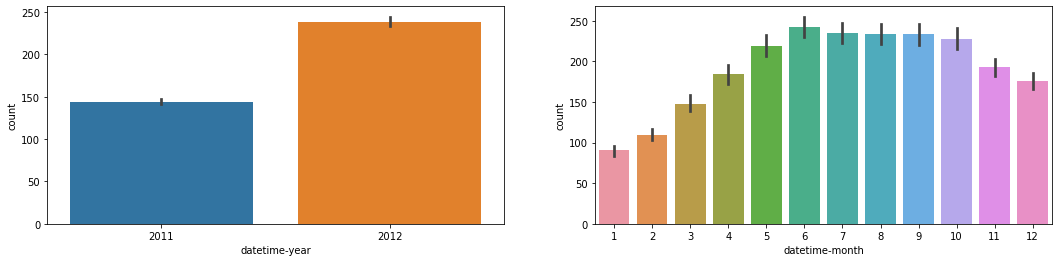

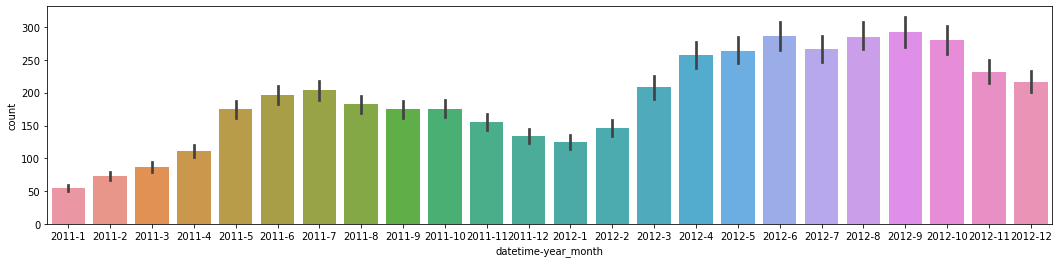

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data = train, x = train['datetime-year'], y = 'count', ax = ax1)
sns.barplot(data = train, x = train['datetime-month'], y = 'count', ax = ax2)

fig, ax3 = plt.subplots(1, 1)
fig.set_size_inches(18, 4)
sns.barplot(data= train, x = train['datetime-year_month'], y = 'count', ax= ax3)

plt.show()

앞서 고민했던, 12월 대비 1, 2월의 차이가 심하다 라는 부분
 1. year_month로 쪼개서 보면, 2011-1월과 2012-1월의 대여량 차이가 꽤 크고,
 2. 2011-12월과 2012-1월의 차이는 별로 없다.
 3. 즉, 꾸준히 고객이 유입되는 단계에서 시기상으로 1월이 먼저 왔을 뿐, 고객의 입장에서 12월이라고 1월보다 더 많이 대여할 이유는 없어보인다.

이 경우, month를 넣으면 overfitting 가능성 높음. 월별 차이는 크게 의미 있어 보이지 않고, 계절 컬럼이 따로 있으므로.

In [18]:
train.groupby('datetime-year_month')['count'].mean()

datetime-year_month
2011-1      54.645012
2011-10    174.773626
2011-11    155.458333
2011-12    134.173246
2011-2      73.641256
2011-3      86.849776
2011-4     111.026374
2011-5     174.809211
2011-6     196.877193
2011-7     203.614035
2011-8     182.666667
2011-9     174.622517
2012-1     124.353201
2012-10    280.508772
2012-11    231.980220
2012-12    217.054825
2012-2     145.646154
2012-3     208.276923
2012-4     257.455947
2012-5     264.109649
2012-6     287.186404
2012-7     267.037281
2012-8     285.570175
2012-9     292.598684
Name: count, dtype: float64

### hour, workingday, and dayofweek 분석
* 시간별 대여량에 더해서, 
    * 근무일과 근무일이 아닌 날의 시간별 대여량은 어떤지
    * 요일별로 시간별 대여량은 어떻게 다른지를 확인한다.

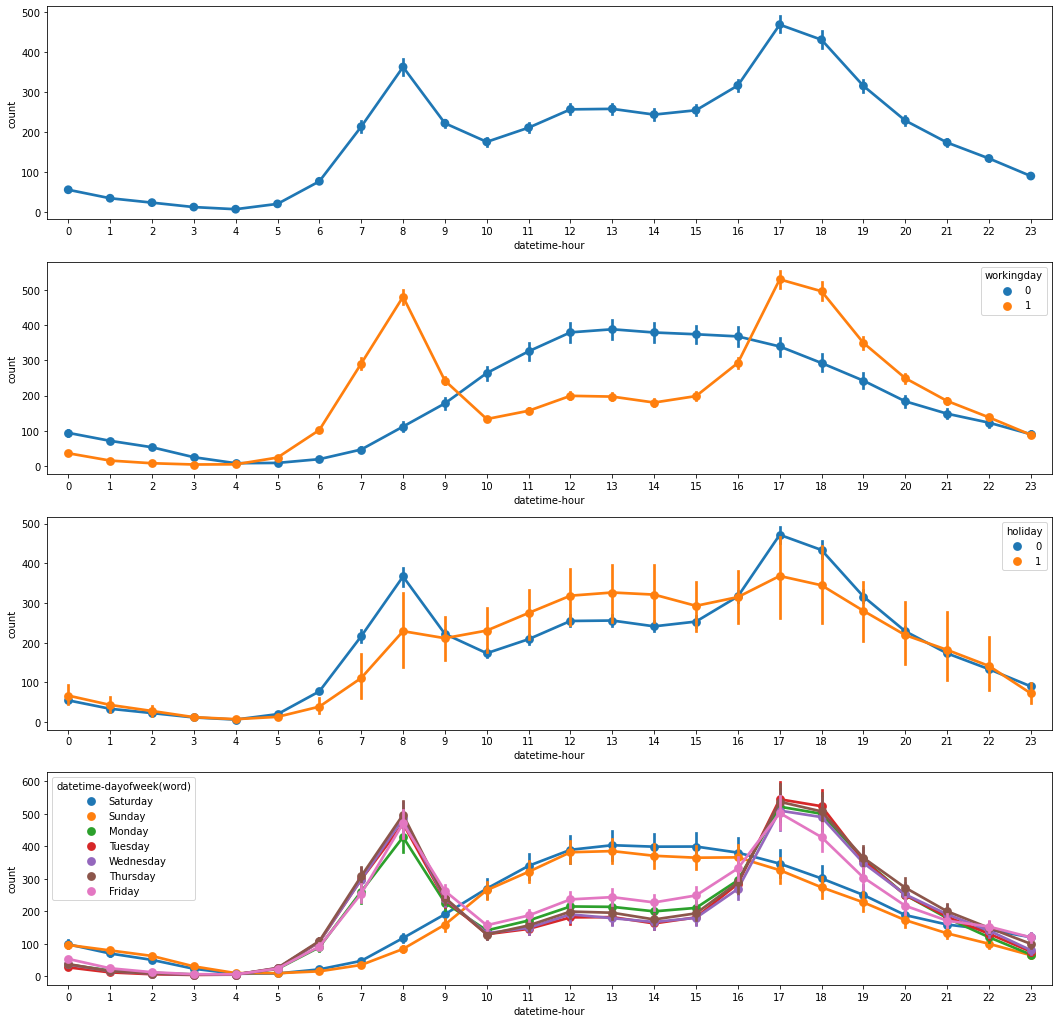

In [256]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
fig.set_size_inches(18, 18)

sns.pointplot(data = train, x = train["datetime-hour"], y = 'count', ax = ax1)
sns.pointplot(data = train, x = train["datetime-hour"], hue = 'workingday', y = 'count', ax = ax2)
sns.pointplot(data = train, x = train["datetime-hour"], hue = 'holiday', y = 'count', ax = ax3)
sns.pointplot(data = train, x = train["datetime-hour"], hue = 'datetime-dayofweek(word)',y = 'count', ax = ax4)

plt.show()

 1. 근무일에는 기본적으로 출 퇴근시간에 많이 대여함
 2. 근무일이 아닌 경우 야외활동이 많은 오후시간에 많이 대여함
 3. 금요일 저녁에는 대여량이 타 요일에 비해 적음: 금요일 약속 많은 것 추정
 4. 주말은 토요일 대여량이 조금 더 높음: 일요일엔 늦잠도 자고, 월요일 출근 고려하여 외부활동 덜 하지 않을까 하는 추정
 5. 결론: 요일을 feature로 추가하면, workingday만 사용하는 것에 비해 더 유의미한 차이를 구분해 낼 것으로 보임. workingday뿐만 아니라, datetime-dayofweek도 feature로 사용하자.

### weather 컬럼 분석
[seaborn barplot](http://hleecaster.com/python-seaborn-barplot/)

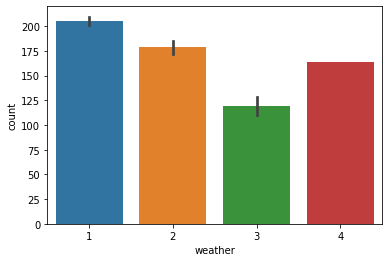

In [20]:
sns.barplot(data = train, x = 'weather', y = 'count')
plt.show()

 중요하게 짚고 넘어가야 할 부분이 있다.
 * barplot의 디폴트는 평균이다.
 * 막대 상단에 표시된 검은 세로선은 각 모집단의 신뢰구간을 의미한다.
     * 디폴트는 ci = 95 이며, ci = 'sd'로 설정하여 표준편차를 볼 수도 있다.
 * 날씨 4를 보면 신뢰구간이 없다. 또한, 날씨가 가장 안 좋음에도 불구하고 2와 별 차이가 없고 3보다 대여량이 높은 편이다.
     * 상식적으로는 납득이 안 가는 부분이므로 날씨 4에 대해 살펴봐야 한다는 점을 알 수 있다. 
     * 그래프가 있는데 신뢰구간이 없다는 것은 날씨 4에 해당하는 관찰값이 1개밖에 없거나 다 똑같다는 것이다.
     * 아래를 보면 날씨4는 max, min, medain 다 같은 값임을 알 수 있고, 피벗으로 돌려보니 1개의 데이터만 있음을 볼 수 있다.

In [21]:
import numpy as np

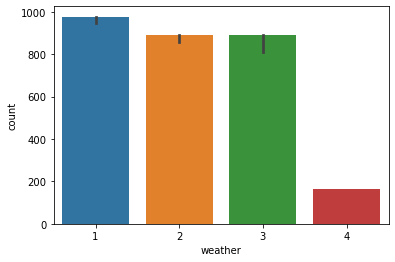

In [22]:
sns.barplot(data = train, x = 'weather', y = 'count', estimator = np.max)
plt.show()

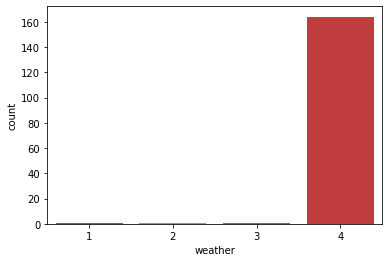

In [23]:
sns.barplot(data = train, x = 'weather', y = 'count', estimator = np.min)
plt.show()

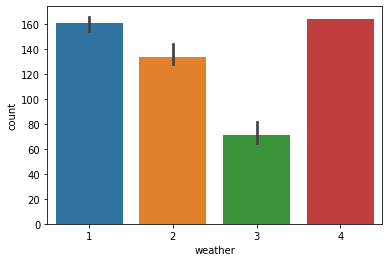

In [24]:
sns.barplot(data = train, x = 'weather', y = 'count', estimator = np.median)
plt.show()

In [25]:
pd.pivot_table(data = train, index = 'weather', values = 'count', aggfunc = 'count', margins = True)

,count
weather,
1,7192
2,2834
3,859
4,1
All,10886


In [26]:
train[train['weather'] == 4]['count']

5631    164
Name: count, dtype: int64

5631번째 행에 해당하는 날에 164개의 대여량이 있는 것을 확인할 수 있다.
 * 이 경우 날씨 4에 해당하는 데이터 행을 아예 삭제하거나,
 * 4를 3으로 바꿔서 날씨 3으로 편입시키는 것이 방법이 된다.

In [27]:
train.loc[train['weather'] == 4, 'weather'] = 3

In [28]:
pd.pivot_table(train, index = 'weather', values = 'count', aggfunc = 'count')

,count
weather,
1,7192
2,2834
3,860


In [29]:
# test데이터도 동일하게 변경
test.loc[test['weather'] == 4, 'weather'] = 3

### Season 분석 

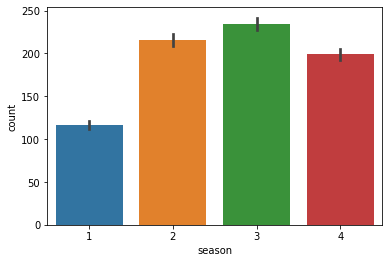

In [30]:
sns.barplot(data = train, x = 'season', y = 'count')
plt.show()

계절은 feature로 의미가 있음

### windspeed 분석 

특이하게도 풍속은 연속형 데이터임에도 불구하고 unique값이 행의 수에 비해 지나치게 적다. 안 좋다는 건 아니고.. 이유가 있겠지 싶다..

In [31]:
train['windspeed'].unique()

array([ 0.    ,  6.0032, 16.9979, 19.0012, 19.9995, 12.998 , 15.0013,
        8.9981, 11.0014, 22.0028, 30.0026, 23.9994, 27.9993, 26.0027,
        7.0015, 32.9975, 36.9974, 31.0009, 35.0008, 39.0007, 43.9989,
       40.9973, 51.9987, 46.0022, 50.0021, 43.0006, 56.9969, 47.9988])

describe해보면, 추측컨데 0이 굉장히 많고 몇몇의 바람이 엄청 부는 날이 있어서 오른쪽으로 긴 분포 형태가 나타날 것으로 보인다.

In [32]:
train['windspeed'].describe()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

위에서 예상하듯, 0이 굉장히 많고, 높은 풍속이 다양하게 퍼져 있음을 알 수 있다.

In [33]:
train['windspeed'].value_counts()

0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
50.0021       1
51.9987       1
Name: windspeed, dtype: int64

In [34]:
pd.pivot_table(train, index = 'windspeed', values = 'count', margins = True)

,count
windspeed,
0.0,161.101295
6.0032,147.864679
7.0015,169.852031
8.9981,175.645536
11.0014,202.262062
12.998,202.249520
15.0013,210.833507
16.9979,214.847087
19.0012,218.051775


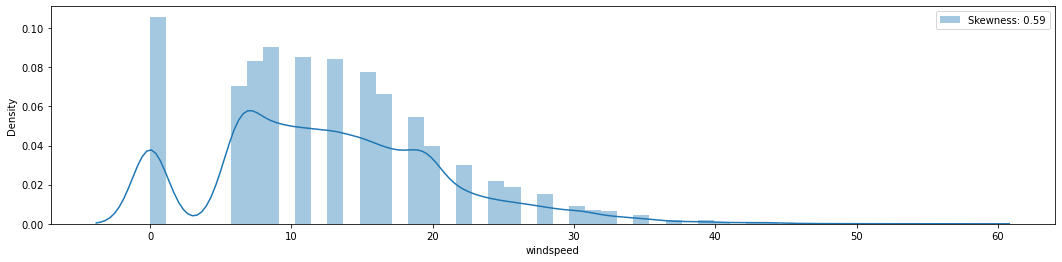

In [35]:
plt.figure(figsize = (18, 4))

sns.distplot(train['windspeed'], label='Skewness: {:.2f}'.format(train['windspeed'].skew())).legend()
plt.show()

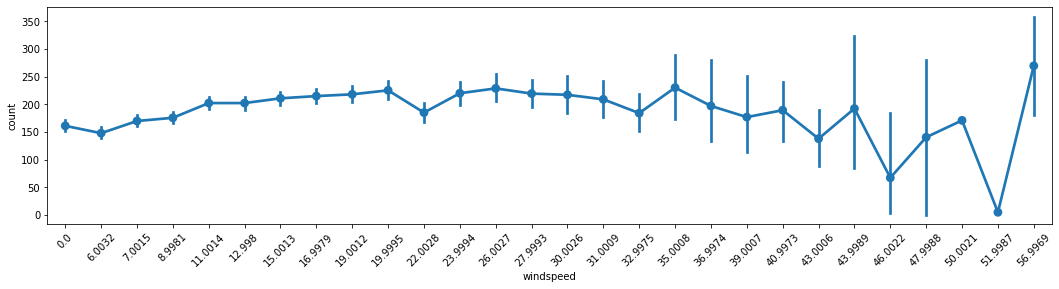

In [36]:
plt.figure(figsize = (18, 4))

sns.pointplot(data = train, x = 'windspeed', y = 'count')
plt.xticks(rotation = 45)
plt.show()

추후 계획

0. 일단 이대로 넣어보고 모델 평가 후, 풍속을 제외한 모델의 평가와 비교한다. 풍속을 넣는 것이 성능이 더 좋다면 아래를 수행한다.
1. 풍속 0은 결측치일수도 있다. 이를 평균으로 대체하는 것이 좋을 것 같다.
2. 단위는 [웨더닷컴](https://weather.com/weather/today/l/38.90,-77.04?par=google)의 워싱턴 날씨를 참고하면 풍속단위를 km/h로 쓰는 것을 알 수 있다.
3. [풍속 환산표](https://typhoon-air.tistory.com/206)를 참고하면, 태풍의 기준이 약 62km/h라는 점을 볼 때 이 데이터에서 가장 높은 풍속은 태풍만큼 열악한 풍속는 아닌 것으로 판단된다.
4. 따라서 나열된 풍속의 종류들은 날씨에 따라 다르겠지만 풍속만 놓고 보면 자전거를 타는 데 무리가 없는 범위로 볼 수 있다.
5. 그리고 일정한 규칙은 없는 것 같다. 예를 들어, 풍속이 46일때 67대를 빌리지만, 47일때 140대를 빌리는 것은 어떻게 설명할 수 있을까?
6. 결론: 0을 평균값으로 대체. 그리고 소수점은 버리고 정수형으로만 해서 다시 feature에 넣어서 모델 재평가 후 판단 

### temp, atemp 컬럼 분석 

In [37]:
train['temp'].unique()

array([ 9.84,  9.02,  8.2 , 13.12, 15.58, 14.76, 17.22, 18.86, 18.04,
       16.4 , 13.94, 12.3 , 10.66,  6.56,  5.74,  7.38,  4.92, 11.48,
        4.1 ,  3.28,  2.46, 21.32, 22.96, 23.78, 24.6 , 19.68, 22.14,
       20.5 , 27.06, 26.24, 25.42, 27.88, 28.7 , 30.34, 31.16, 29.52,
       33.62, 35.26, 36.9 , 32.8 , 31.98, 34.44, 36.08, 37.72, 38.54,
        1.64,  0.82, 39.36, 41.  ])

In [38]:
train['atemp'].unique()

array([14.395, 13.635, 12.88 , 17.425, 19.695, 16.665, 21.21 , 22.725,
       21.97 , 20.455, 11.365, 10.605,  9.85 ,  8.335,  6.82 ,  5.305,
        6.06 ,  9.09 , 12.12 ,  7.575, 15.91 ,  3.03 ,  3.79 ,  4.545,
       15.15 , 18.18 , 25.   , 26.515, 27.275, 29.545, 23.485, 25.76 ,
       31.06 , 30.305, 24.24 , 18.94 , 31.82 , 32.575, 33.335, 28.79 ,
       34.85 , 35.605, 37.12 , 40.15 , 41.665, 40.91 , 39.395, 34.09 ,
       28.03 , 36.365, 37.88 , 42.425, 43.94 , 38.635,  1.515,  0.76 ,
        2.275, 43.18 , 44.695, 45.455])

temp, atemp 전부 unique값이 많지 않다. 그것보다 중요한건 영하 기온이 없다는 것이다.

[워싱턴겨울날씨](https://www.google.com/search?q=%EC%9B%8C%EC%8B%B1%ED%84%B4+%EA%B2%A8%EC%9A%B8+%EB%82%A0%EC%94%A8&oq=%EC%9B%8C%EC%8B%B1%ED%84%B4+%EA%B2%A8%EC%9A%B8+%EB%82%A0%EC%94%A8&aqs=chrome..69i57.4970j0j4&sourceid=chrome&ie=UTF-8)를 참고하면 답이 나온다. 

일별 최고기온으로 기록된 것이다.

In [39]:
train[train['datetime-month'] == 1][['datetime-month','temp', 'atemp']]

,datetime-month,temp,atemp
0,1,9.84,14.395
1,1,9.02,13.635
2,1,9.02,13.635
3,1,9.84,14.395
4,1,9.84,14.395
...,...,...,...
5870,1,10.66,11.365
5871,1,10.66,10.605
5872,1,10.66,11.365
5873,1,10.66,11.365


우선, 월별 평균기온을 한 번 살펴본다.

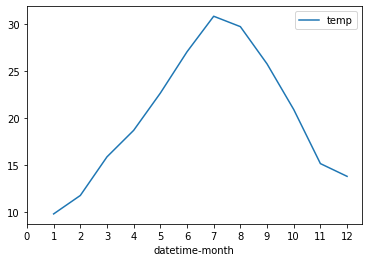

In [40]:
pd.pivot_table(train, index = 'datetime-month', values = 'temp').plot()
plt.xticks(np.arange(0, 13, 1))

plt.show()

In [41]:
pd.pivot_table(train, index = 'season', values = 'temp')

,temp
season,
1,12.530491
2,22.823483
3,28.789111
4,16.649239


위에서 datetime 분석할 때 2011년 12월과 2012년 1월이 큰 차이는 없지만 1월 들어서 대여량이 감소한 이유가 여기서 설명이 된다.

다만, 온도 변화에 따른 대여량은 월, 또는 계절로 이미 가능하기 때문에 temp와 atemp를 의미있게 쓸 방법을 한 번 찾아보자.

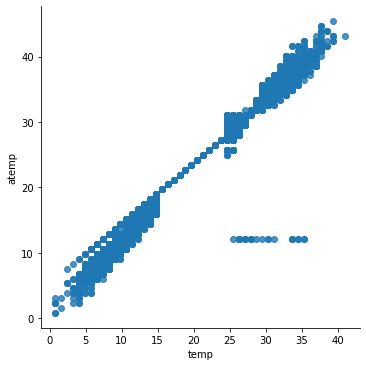

In [42]:
sns.lmplot(data = train, x = 'temp', y = 'atemp', fit_reg = False) 
plt.show()

temp와 atemp는 상관관계가 굉장히 높은 것을 알 수 있다.

둘의 차이는 어떤 의미가 있을까? 를 살펴본다.

In [43]:
train['temp(difference)'] = round(train['temp'] - train['atemp'])

train['temp(difference)'].unique()

array([-5., -3., -4., -2., -1., -0.,  1., -6., -7., -8.,  2., 16., 15.,
       14., 13., 17., 18., 19., 22., 23.])

In [44]:
# test데이터도 동일하게 변경
test['temp(difference)'] = round(test['temp'] - test['atemp'])

test['temp(difference)'].unique()

array([ -1.,  -3.,  -2.,  -4.,  -0.,   1.,   2.,  -5.,  -6.,  -7.,  -9.,
        -8., -10., -11.])

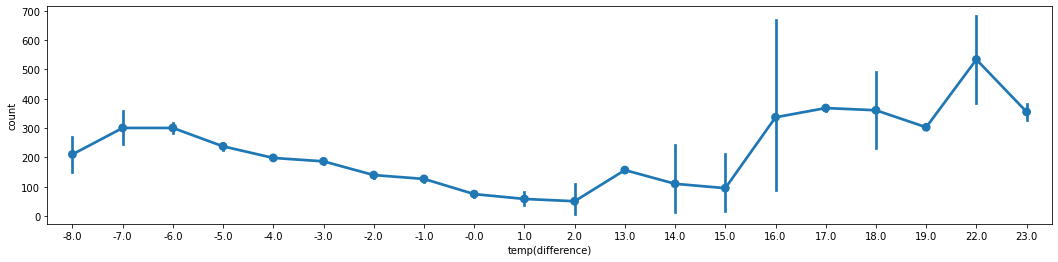

In [45]:
plt.figure(figsize = (18, 4))
sns.pointplot(data = train, x = 'temp(difference)', y = 'count')

plt.show()

In [46]:
train['temp(difference)'].value_counts()

-4.0     5214
-3.0     1926
-2.0     1331
-5.0     1106
-1.0      581
-6.0      448
-0.0      195
-7.0       32
 1.0       23
 14.0       5
 22.0       5
 2.0        4
 15.0       3
 16.0       3
-8.0        2
 17.0       2
 23.0       2
 18.0       2
 13.0       1
 19.0       1
Name: temp(difference), dtype: int64

temp(difference)에 따라 차이가 크면 대여량이 더 높다는 사실을 알 수 있다 !!

그러나, 각 unique별 개수를 보면 모수가 적은 것들이 너무 많다. 일단 이대로 모델에 넣어보자

모델 평가 후 비교할 부분은,

* 상대적으로 모수가 적은 양수값들은 차이에 따른 대여량은 유의미하나 모델에 넣는 것이 의미 없을 것이다.
* 따라서 마이너스 수치들만(체감온도가 더 높은 날) 분석되도록 0 이상의 값을 0으로 통일하고 모델에 넣어 보고 비교할 것이다.

### humidity 컬럼 분석

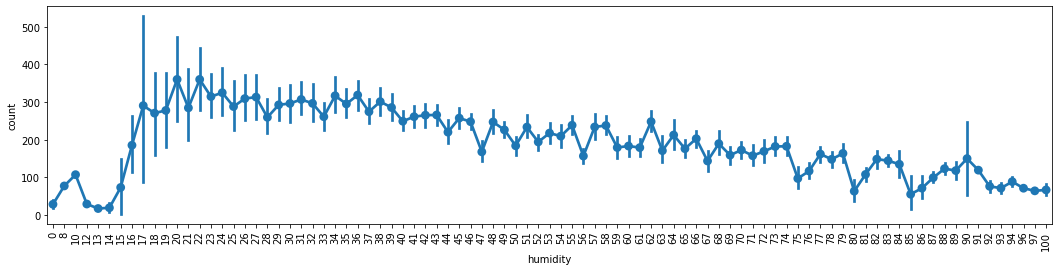

In [47]:
plt.figure(figsize = (18, 4))
sns.pointplot(data = train, x = 'humidity', y = 'count')
plt.xticks(rotation = 90)
plt.show()

습도가 너무 낮아도 대여량이 낮고,

습도 약 15% 정도에서 대여량이 증가하며 40%정도를 넘어가면 감소폭이 커짐을 알 수 있다.

이대로 넣어도 모델이 충분히 구분할 수 있을 것으로 보인다.

### casual, registered 컬럼 분석

In [48]:
len(train[train['casual'] >= 1]) / len(train), len(train[train['registered']>=1]) / len(train)

(0.9094249494763917, 0.9986220834098842)

casual, registered 모두 값이 들어 있는 비율이 높으므로 분석이 용이하다.

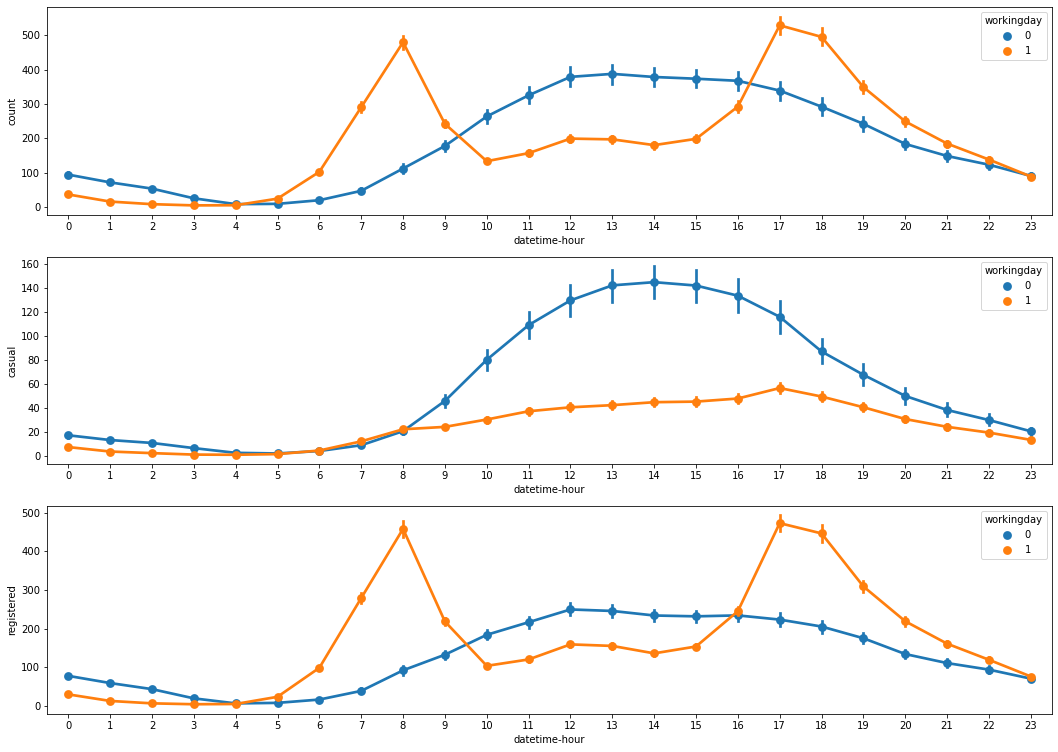

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(18, 13)

sns.pointplot(data = train, x = 'datetime-hour', y = 'count', hue = 'workingday', ax = ax1)
sns.pointplot(data = train, x = 'datetime-hour', y = 'casual', hue = 'workingday', ax = ax2)
sns.pointplot(data = train, x = 'datetime-hour', y = 'registered', hue = 'workingday', ax = ax3)

plt.show()

시간당 비회원, 회원의 이용 행태를 전체와 비교하면,

1. 비회원: 근무일이 아닌 날의 야외활동 시간에 주로 이용함
2. 회원: 근무일인 날의 출퇴근 시간에 주로 이용함

즉, 회원과 비회원의 이용 목적이 극명하게 차이가 있음을 알 수 있다 !!

이 경우, test데이터에는 casual과 registered가 없기 때문에, 이 두 컬럼을 제외하고 예측을 해버리면 이러한 특성이 반영이 안 될 수도 있다.

따라서 model fitting 시 casual과 registered를 각각 예측한 뒤, 이를 더한 값을 test 데이터의 count로 넣으면 더욱 정교해질 수 있다고 판단된다.

## Preprocessing

### 불쾌지수 만들기
* [불쾌지수=1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32]
* [설명](https://www.kma.go.kr/HELP/basic/help_01_05.jsp)
    * 매우높음: 80이상. 전원 불쾌감을 느낌
    * 높음    : 75~80미만. 50% 정도 불쾌감을 느낌
    * 보통    : 68~75미만. 불쾌감을 나타내기 시작함
    * 낮음    : 68미만. 전원 쾌적함을 느낌

In [52]:
train['discomfort_idx'] = (1.8 * train['temp']) - (0.55) * (1 - (train['humidity']/100)) * (1.8*(train['temp']/100)-26) + 32
test['discomfort_idx'] = (1.8 * test['temp']) - (0.55) * (1 - (test['humidity']/100)) * (1.8*(test['temp']/100)-26) + 32

In [53]:
train['discomfort_idx']

0        52.410491
1        51.078140
2        51.078140
3        53.262646
4        53.262646
           ...    
10881    67.116879
10882    64.654167
10883    62.615178
10884    62.615178
10885    60.433838
Name: discomfort_idx, Length: 10886, dtype: float64

<AxesSubplot:xlabel='discomfort_idx', ylabel='Count'>

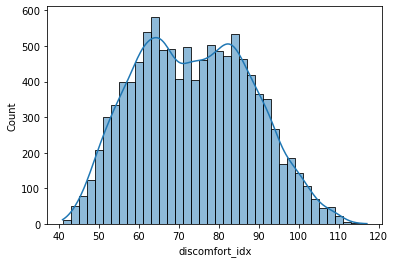

In [54]:
sns.histplot(data = train, x = 'discomfort_idx', kde = True)

In [55]:
train['discomfort_idx'].describe()

count    10886.000000
mean        73.788484
std         14.424431
min         40.900181
25%         62.275953
50%         73.541698
75%         84.568078
max        117.054221
Name: discomfort_idx, dtype: float64

### 풍속 == 0을 평균으로 대체

In [110]:
test[test['windspeed'] == 0]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,...,datetime-minute,datetime-second,datetime-dayofweek,datetime-dayofweek(word),datetime-year(str),datetime-month(str),datetime-year_month,temp(difference),discomfort_idx,ym_encode
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0,2011,...,0,0,3,Thursday,2011,1,2011-1,-3.0,57.433565,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0,2011,...,0,0,3,Thursday,2011,1,2011-1,-3.0,57.433565,0
12,2011-01-20 12:00:00,1,0,1,2,12.30,16.665,42,0.0,2011,...,0,0,3,Thursday,2011,1,2011-1,-4.0,62.363373,0
60,2011-01-22 13:00:00,1,0,0,1,3.28,8.335,35,0.0,2011,...,0,0,5,Saturday,2011,1,2011-1,-5.0,47.177893,0
62,2011-01-22 15:00:00,1,0,0,1,4.92,7.575,28,0.0,2011,...,0,0,5,Saturday,2011,1,2011-1,-3.0,51.116930,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,2012-12-29 12:00:00,1,0,0,3,8.20,12.120,100,0.0,2012,...,0,0,5,Saturday,2012,12,2012-12,-4.0,46.760000,15
6434,2012-12-29 13:00:00,1,0,0,3,8.20,12.120,100,0.0,2012,...,0,0,5,Saturday,2012,12,2012-12,-4.0,46.760000,15
6436,2012-12-29 15:00:00,1,0,0,2,9.84,12.120,87,0.0,2012,...,0,0,5,Saturday,2012,12,2012-12,-2.0,51.558336,15
6444,2012-12-29 23:00:00,1,0,0,2,10.66,12.120,60,0.0,2012,...,0,0,5,Saturday,2012,12,2012-12,-1.0,56.865786,15


In [107]:
train['windspeed'].mean()

12.799395406945093

In [108]:
train.loc[train['windspeed'] == 0, 'windspeed'] = train['windspeed'].mean()

In [111]:
test['windspeed'].mean()

12.63115720006173

In [112]:
test.loc[test['windspeed'] == 0, 'windspeed'] = test['windspeed'].mean()

## Train
* feature: season, holiday, workingday, weather, temp, atemp, humidity, windspeed, datetime-year, datetime-hour, datetime-dayofweek
* lable: count


* X_train: train데이터의 feature
* Y_train: train데이터의 lable
* X_test: test데이터의 feature

In [146]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'datetime-year', 'datetime-month', 'datetime-day', 'datetime-hour',
       'datetime-minute', 'datetime-second', 'datetime-dayofweek',
       'datetime-dayofweek(word)', 'datetime-year(str)', 'datetime-month(str)',
       'datetime-year_month', 'temp(difference)', 'discomfort_idx',
       'year_month_label', 'ym_encode', 'temp(difference_rvsd)'],
      dtype='object')

In [200]:
feature_names = ["season", "holiday", "workingday", "weather",
                 'temp', 'atemp', 'humidity', 'windspeed',
                 "datetime-year", "datetime-hour", "datetime-dayofweek", "discomfort_idx"]
feature_names

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'datetime-year',
 'datetime-hour',
 'datetime-dayofweek',
 'discomfort_idx']

In [201]:
lable_name = "count"

lable_name

'count'

In [202]:
X_train = train[feature_names]

print(X_train.shape)

X_train.head()

(10886, 12)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-hour,datetime-dayofweek,discomfort_idx
0,1,0,0,1,9.84,14.395,81,12.799395,2011,0,5,52.410491
1,1,0,0,1,9.02,13.635,80,12.799395,2011,1,5,51.078140
2,1,0,0,1,9.02,13.635,80,12.799395,2011,2,5,51.078140
3,1,0,0,1,9.84,14.395,75,12.799395,2011,3,5,53.262646
4,1,0,0,1,9.84,14.395,75,12.799395,2011,4,5,53.262646


In [203]:
X_test = test[feature_names]

print(X_test.shape)

X_test.head()

(6493, 12)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-hour,datetime-dayofweek,discomfort_idx
0,1,0,1,1,10.66,11.365,56,26.002700,2011,0,3,57.433565
1,1,0,1,1,10.66,13.635,56,12.631157,2011,1,3,57.433565
2,1,0,1,1,10.66,13.635,56,12.631157,2011,2,3,57.433565
3,1,0,1,1,10.66,12.880,56,11.001400,2011,3,3,57.433565
4,1,0,1,1,10.66,12.880,56,11.001400,2011,4,3,57.433565


In [204]:
Y_train = train[lable_name]

print(Y_train.shape)

Y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

## Use Random Forest Regressor

In [248]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=1618, max_depth = 20, min_samples_split = 2, n_estimators = 150)

model

RandomForestRegressor(max_depth=20, n_estimators=150, n_jobs=-1,
                      random_state=1618)

## Cross Validation

In [249]:
from sklearn.model_selection import cross_val_predict

Y_predict = cross_val_predict(model, X_train, Y_train, cv=20)

print(Y_predict.shape)
Y_predict[:5]

(10886,)


array([29.48      , 23.02666667, 20.14666667, 11.45111111,  4.38      ])

## Evaluate

In [250]:
import numpy as np

from sklearn.metrics import mean_squared_log_error

msle = mean_squared_log_error(Y_train, Y_predict)

score = np.sqrt(msle)

print("Score = {0:.5f}".format(score))

Score = 0.38228


## GridSearch 

In [230]:
from sklearn.model_selection import GridSearchCV

In [244]:
RF_param_grid = {'n_estimators':[100, 150, 200, 300, 400, 500],
                'max_depth' : [10, 15, 20, 30],
                 'min_samples_split' : [2, 3, 4]
                }

In [245]:
RF_grid = GridSearchCV(model, param_grid = RF_param_grid, scoring = 'neg_mean_squared_log_error',
                      n_jobs = -1, verbose = 1)

RF_grid.fit(X_train, Y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.6min finished


GridSearchCV(estimator=RandomForestRegressor(max_depth=15, n_jobs=-1,
                                             random_state=1618),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 30],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 150, 200, 300, 400, 500]},
             scoring='neg_mean_squared_log_error', verbose=1)

In [246]:
print(RF_grid.best_score_,'\n',RF_grid.best_params_)

-0.25561728411026785 
 {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}


In [247]:
np.sqrt(-1*RF_grid.best_score_)

0.5055860798224847

## Fit

In [251]:
model.fit(X_train, train["casual"])
casual_prediction = model.predict(X_test)

model.fit(X_train, train["registered"])
registered_prediction = model.predict(X_test)

## Prediction

In [252]:
predictions = casual_prediction + registered_prediction

print(predictions.shape)
predictions

(6493,)


array([11.93333333,  6.068     ,  3.29845791, ..., 91.91392716,
       97.35336111, 45.64717929])

## Submit

In [253]:
submission = pd.read_csv("sampleSubmission.csv")

print(submission.shape)

submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [254]:
submission["count"] = predictions

print(submission.shape)

submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.933333
1,2011-01-20 01:00:00,6.068000
2,2011-01-20 02:00:00,3.298458
3,2011-01-20 03:00:00,2.705668
4,2011-01-20 04:00:00,2.473075


In [255]:
submission.to_csv("submission_7.csv", index=False)